# IDEA:

Train on the derivative

# Imports:

In [101]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)
from sklearn import decomposition

import rescomp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Lorenz iterator:

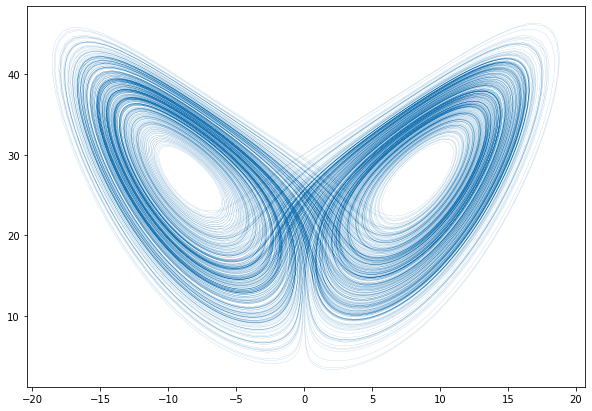

In [102]:
# Lorenz parameters:
dt_L = 0.01
lyap_L = 0.934
starting_point_L = np.array([0, 1, 0])
# starting_point_L = np.array([-14.03020521, -20.88693127, 25.53545])

# lorenz iterator:
def data_creation_function_L(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function_L(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 50000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series_L = time_series_all[disc_steps:, :]

plt.plot(time_series_L[:, 0], time_series_L[:, 2], linewidth=0.1)

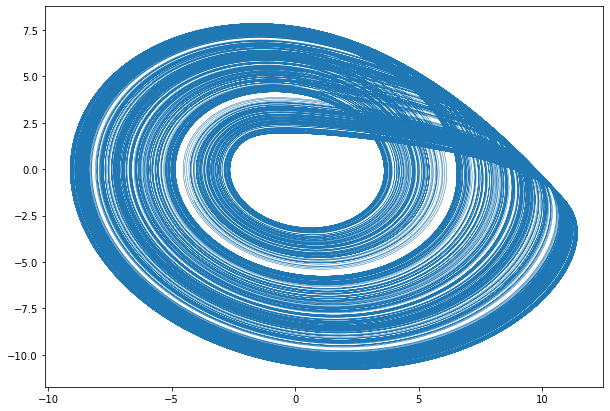

In [103]:
# Roessler parameters:
dt_R = 0.05
lyap_R = 1
starting_point_R = np.array([0, 1, 0])

# Roessler iterator:
def data_creation_function_R(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("roessler_sprott", dt, time_steps, starting_point)

def f_R(x):
    return data_creation_function_R(2, dt_R, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 50000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_R

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_R(x_last)

time_series_R = time_series_all[disc_steps:, :]

plt.plot(time_series_R[:, 0], time_series_R[:, 1], linewidth=0.5)

# Create the ESN architecture:

In [195]:
esn = rescomp.ESNWrapper()
esn.set_console_logger("debug")
ndim = 200
esn.create_architecture(ndim, 3, w_out=np.random.randn(3, ndim), seed=120, w_out_fit_flag="simple", leak_fct=0.5, activation_function="sigmoid")
esn.summary()

03-10 20:57:21 [DEBUG  ] Create network
03-10 20:57:21 [DEBUG  ] Create w_in
03-10 20:57:21 [DEBUG  ] Set activation function to flag: sigmoid
03-10 20:57:21 [DEBUG  ] _w_out_fit_flag set to simple
03-10 20:57:21 [DEBUG  ] Setting self._w_out with the set_w_out function
03-10 20:57:21 [DEBUG  ] ESN can run in loop
INPUT: 
x_dim: 3
INPUT-RESERVOIR COUPLING W_in: 
W_in: (200, 3)
- - - - - - - - - - -
w_in_scale: 1.0, w_in_sparse: True, w_in_ordered: False
RESERVOIR: 
- - - - - - - - - - -
Network: 
n_dim: 200
n_rad: 0.1, n_avg_deg: 6.0, n_type_flag: erdos_renyi, 
- - - - - - - - - - -
Dynamics: 
act_fct_flag: sigmoid, bias_scale: 0, leak_factor: 0.5
Update equation: r(i+1) = leak_fct * r(i) + (1-leak_fct) * act_fct(W_in * x(i) + W * r(i))
NON-LINEAR TRANSFORM OF RESERVOIR STATE: 
w_out_fit_flag: simple
RESERVOIR-OUTPUT COUPLING W_out: 
W_out: (3, 200)



# Train reservoir on time-derivative of time-series:

### Synchronize reservoir with time_series input and save reservoir states:

In [214]:
time_series = time_series_R
dt = dt_R

# time_series = time_series_L
# dt = dt_L

In [215]:
esn.reset_res_state()
train_steps = 5000
sync_steps = 100
x_train_sync = time_series[:sync_steps]
x_train = time_series[sync_steps : sync_steps + train_steps]

# sync:
esn.synchronize(x_train_sync, save_r=False)

# "training":
r = esn.synchronize(x_train, save_r=True)

03-10 21:01:13 [DEBUG  ] Start syncing the reservoir state
03-10 21:01:13 [DEBUG  ] Start syncing the reservoir state


### Fit to time-derivative:

first entry of r corresponds to the first entry of the time_series
d_time_series has -1 entry



In [216]:
d_time_series = (time_series[1:] - time_series[:-1])/dt

In [217]:
y_train = d_time_series[sync_steps:train_steps+sync_steps]
print(y_train.shape)
print(r.shape)

(5000, 3)
(5000, 200)


In [218]:
reg_param = 1e-7

esn._w_out = np.linalg.solve(
    r.T @ r + reg_param * np.eye(r.shape[1]),
    r.T @ y_train).T

### Predict:

In [219]:
test_steps = 10000
test_sync_steps = 100
x_test_sync = time_series[sync_steps + train_steps : train_steps + sync_steps + test_sync_steps]
x_test = time_series[sync_steps + train_steps + test_sync_steps: train_steps + sync_steps + test_steps + test_sync_steps]
y_test = d_time_series[sync_steps + train_steps + test_sync_steps: train_steps + sync_steps + test_steps + test_sync_steps]
print(x_test_sync.shape)
print(x_test.shape)
print(y_test.shape)

(100, 3)
(10000, 3)
(10000, 3)


In [220]:
# sync reservoir:
esn.reset_res_state()
esn.synchronize(x_test_sync)

# predict:
y_test_pred = np.zeros(y_test.shape)
x_test_pred = np.zeros(y_test.shape)

y_test_pred[0, :] = esn._predict_step(x_test[0, :])
x_test_pred[0, :] = x_test[0, :] + y_test_pred[0, :]*dt

for t in range(1, test_steps):
    y_test_pred[t, :] = esn._predict_step(x_test_pred[t-1, :])
    x_test_pred[t, :] = x_test_pred[t-1, :] + y_test_pred[t, :]*dt

03-10 21:01:14 [DEBUG  ] Start syncing the reservoir state


### Plot:

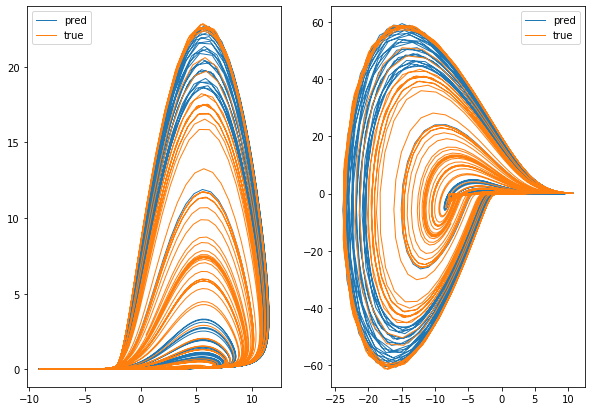

In [221]:
plt.subplot(121)
plt.plot(x_test_pred[:, 0], x_test_pred[:, 2], linewidth=1, label="pred")
plt.plot(x_test[:, 0], x_test[:, 2], linewidth=1, label="true")
plt.legend()

plt.subplot(122)
plt.plot(y_test_pred[:, 0], y_test_pred[:, 2], linewidth=1, label="pred")
plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1, label="true")
plt.legend()

(0, 1000)

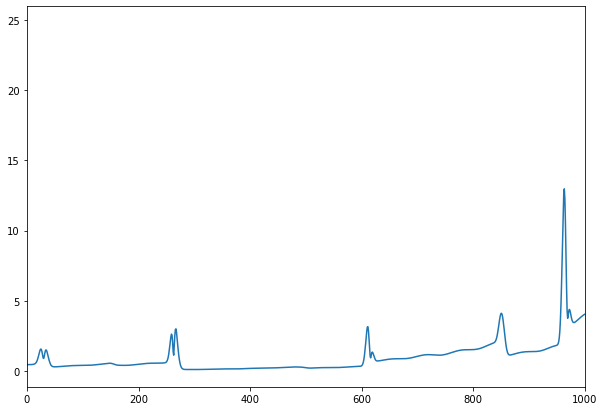

In [222]:
# plot the error over time:
error = rescomp.measures.error_over_time(x_test_pred, x_test)
plt.plot(error)
plt.xlim(0, 1000)

# Comparison to baseline - Train on next time step:

In [223]:
# Train:

esn.reset_res_state()
# sync:
esn.synchronize(x_train_sync, save_r=False)
# training:
esn.train(x_train, sync_steps=None, save_r=False, reg_param=reg_param)

03-10 21:01:18 [DEBUG  ] Start syncing the reservoir state
03-10 21:01:18 [DEBUG  ] Create w_in
03-10 21:01:18 [DEBUG  ] Start syncing the reservoir state
03-10 21:01:18 [DEBUG  ] Start training
03-10 21:01:18 [DEBUG  ] Start syncing the reservoir state
03-10 21:01:18 [DEBUG  ] Fit _w_out according to method 0


In [224]:
# sync reservoir:
esn.reset_res_state()
esn.synchronize(x_test_sync)

# predict:
x_test_pred_base = np.zeros(x_test.shape)
x_test_pred_base[0, :] = esn._predict_step(x_test[0, :])

for t in range(1, test_steps):
    x_test_pred_base[t, :] = esn._predict_step(x_test_pred_base[t-1, :])

03-10 21:01:18 [DEBUG  ] Start syncing the reservoir state


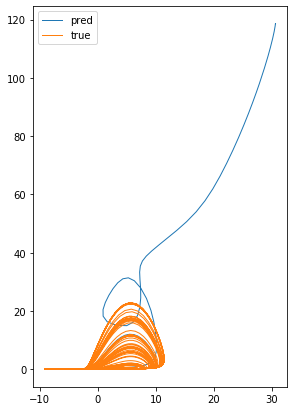

In [225]:
plt.subplot(121)
plt.plot(x_test_pred_base[:, 0], x_test_pred_base[:, 2], linewidth=1, label="pred")
plt.plot(x_test[:, 0], x_test[:, 2], linewidth=1, label="true")
plt.legend()

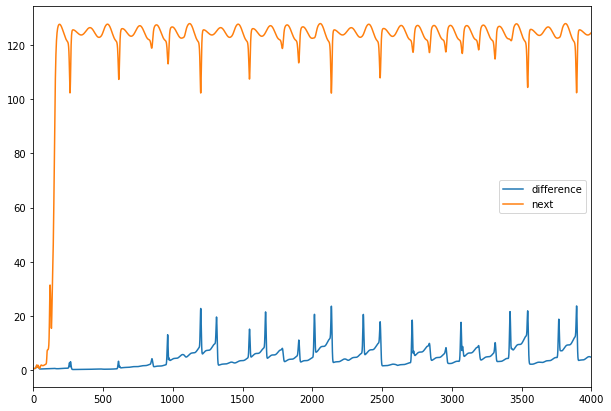

In [226]:
# plot the error over time:
error_base = rescomp.measures.error_over_time(x_test_pred_base, x_test)
plt.plot(error, label="difference")
plt.plot(error_base, label="next")
plt.xlim(0, 4000)
plt.legend()

# Further Comparison:

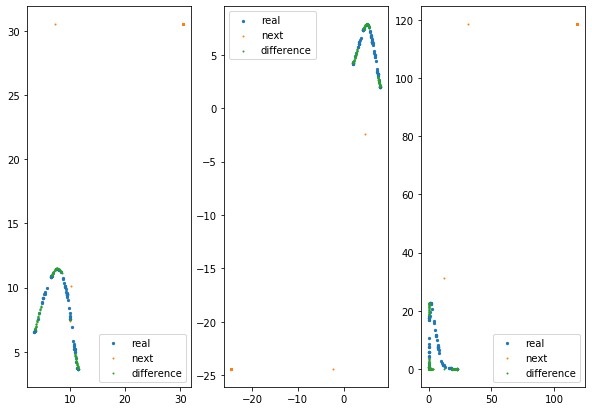

In [227]:
# "Poincare" Map:

mode="maxima"
for ix in range(3):
    plt.subplot(f"13{ix+1}")

    x, y = rescomp.measures.poincare_map(x_test, dimension=ix, mode=mode)
    plt.scatter(x, y, label="real", s=5)

    x, y = rescomp.measures.poincare_map(x_test_pred_base, dimension=ix, mode=mode)
    plt.scatter(x, y, label="next", s=1)

    x, y = rescomp.measures.poincare_map(x_test_pred, dimension=ix, mode=mode)
    plt.scatter(x, y, label="difference", s=1)

    plt.legend()

avg period: 5.5904330721689774
For 0/10000 points, all 50 closest neighbours were temporally closer than 5.5904330721689774 and thus not considered
For 968/10000 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 9032
avg period: 5.288716312841712
For 0/10000 points, all 50 closest neighbours were temporally closer than 5.288716312841712 and thus not considered
For 772/10000 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 9228
avg period: 23.691414544338045
For 0/10000 points, all 50 closest neighbours were temporally closer than 23.691414544338045 and thus not considered
For 707/10000 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 1002


C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\measures.py:947: RuntimeWarning: divide by zero encountered in log
  log_d = np.log(d_no_zero)


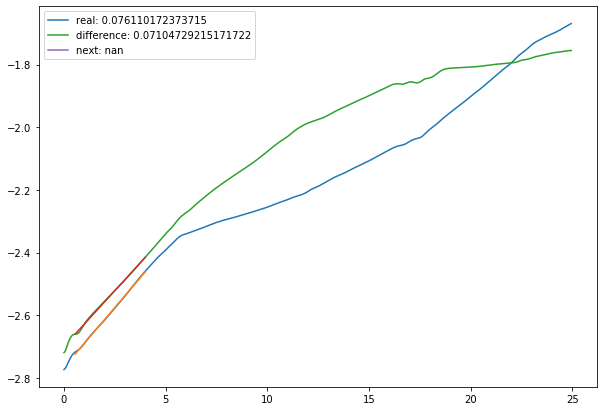

In [228]:
t_min, t_max = 0.6, 4
steps = 500

out = rescomp.measures.lyapunov_rosenstein(x_test, dt=dt, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"real: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(x_test_pred, dt=dt, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"difference: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(x_test_pred_base, dt=dt, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"next: {coef[0]}")
plt.plot(x_fit, y_fit)

plt.legend()

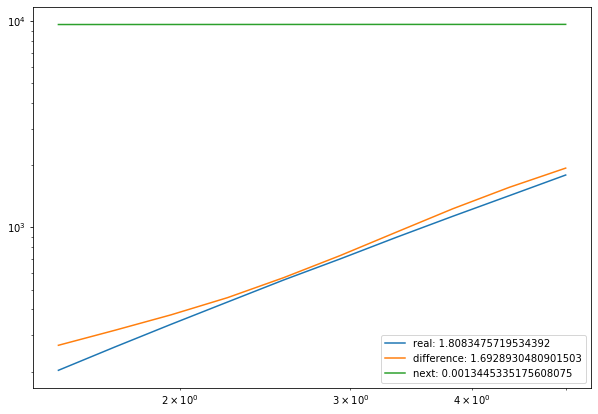

In [229]:
# Correlation Dimension:

sloap, N_r = rescomp.measures.dimension(x_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(x_test_pred, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"difference: {sloap}")

sloap, N_r = rescomp.measures.dimension(x_test_pred_base, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"next: {sloap}")

plt.legend()

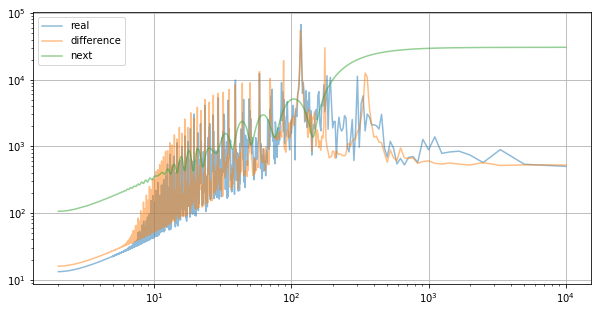

In [230]:
# Fourier Spectrum (Period):
plt.figure(figsize=(10, 5))

x, y = rescomp.measures.fourier_spectrum(x_test, period=True)
plt.plot(x,y, label="real", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(x_test_pred, period=True)
plt.plot(x,y, label="difference", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(x_test_pred_base, period=True)
plt.plot(x,y, label="next", alpha=0.5)

# plt.xlim(-0.01, 0.02)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend()

---------------------